In [ ]:
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import shap
import matplotlib.pyplot as plt

In [ ]:
#generating a synthetic data
np.random.seed(42)

NUM_USERS = 1000
NUM_MERCHANTS = 100
NUM_TXNS = 12000
FRAUD_RATE = 0.03

users = [f"user_{i}" for i in range(NUM_USERS)]
merchants = [f"merchant_{i}" for i in range(NUM_MERCHANTS)]
cities = ["Delhi", "Mumbai", "Bangalore", "Noida", "Pune"]
payment_methods = ["UPI", "Credit Card", "Debit Card", "NetBanking"]
devices = [f"device_{i}" for i in range(2000)]

data = []
start_time = datetime.now() - timedelta(days=30)

for i in range(NUM_TXNS):
    user = random.choice(users)
    merchant = random.choice(merchants)
    amount = np.round(np.random.exponential(scale=1500), 2)
    timestamp = start_time + timedelta(minutes=i*2)
    city = random.choice(cities)
    payment_method = random.choice(payment_methods)
    device = random.choice(devices)
    is_fraud = 0

    # Fraud patterns
    if np.random.rand() < FRAUD_RATE:
        is_fraud = 1
        amount = np.round(amount * np.random.randint(5, 12), 2)
        city = random.choice([c for c in cities if c != city])

    data.append([f"txn_{i}", user, merchant, amount, timestamp, city, payment_method, device, is_fraud])

df = pd.DataFrame(data, columns=[
    "transaction_id", "user_id", "merchant_id", "amount",
    "timestamp", "location", "payment_method", "device_id", "is_fraud"
])

df.head()

,transaction_id,user_id,merchant_id,amount,timestamp,location,payment_method,device_id,is_fraud
0,txn_0,user_932,merchant_98,703.90,2026-01-21 12:59:54.716628,Mumbai,Debit Card,device_801,0
1,txn_1,user_428,merchant_63,1975.12,2026-01-21 13:01:54.716628,Noida,UPI,device_710,0
2,txn_2,user_881,merchant_39,254.44,2026-01-21 13:03:54.716628,Delhi,UPI,device_562,0
3,txn_3,user_439,merchant_21,89.76,2026-01-21 13:05:54.716628,Delhi,Debit Card,device_658,0
4,txn_4,user_563,merchant_66,1378.62,2026-01-21 13:07:54.716628,Delhi,NetBanking,device_1425,0


In [ ]:
#feature engineering block

df["hour"] = df["timestamp"].dt.hour
df["amount_log"] = np.log1p(df["amount"])

user_avg = df.groupby("user_id")["amount"].transform("mean")
df["amount_deviation"] = df["amount"] - user_avg

df["user_txn_count"] = df.groupby("user_id")["transaction_id"].transform("count")

df = pd.get_dummies(df, columns=["location", "payment_method"])

In [ ]:

X = df.drop(columns=["transaction_id", "user_id", "merchant_id", "device_id", "timestamp", "is_fraud"]) #dropping the unwanted coulmns that do not add any improvement into mdole training instead it causes memorization if coulmns where not deleted
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)  #converting into training and testing data.

model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42) # applying random forrest coz it learns better on non-linera dataset and also good at feature interactions and mixed faeture type
model.fit(X_train, y_train)  #this trains the model

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:

#model evaluation step
y_pred = model.predict(X_test)  #predicts the fraud and legit transaction as 1 or 0
y_proba = model.predict_proba(X_test)[:,1]# it predicts the precentage probablity

print("ROC-AUC:", roc_auc_score(y_test, y_proba))  #How well the model ranks fraud higher than legit transactions.
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

ROC-AUC: 0.8213555170076908
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2331
           1       0.74      0.42      0.54        69

    accuracy                           0.98      2400
   macro avg       0.86      0.71      0.76      2400
weighted avg       0.98      0.98      0.98      2400

Confusion Matrix:
 [[2321   10]
 [  40   29]]


/tmp/ipython-input-4095048735.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:200])
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


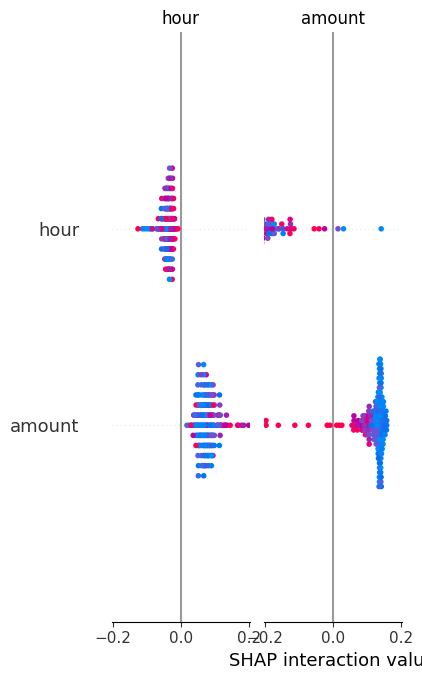

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:200])  #SHAP TreeExplainer to interpret predictions from the Random Forest model.

# For binary classification, shap_values may be a list
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_test[:200])

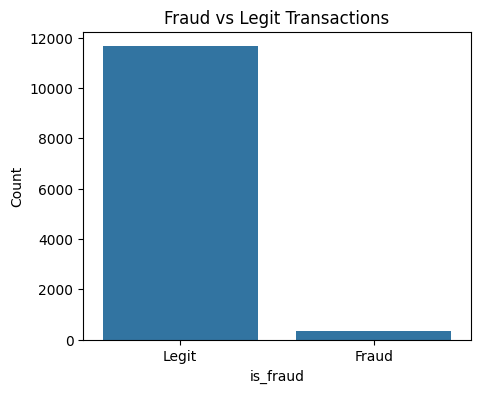

In [ ]:
#Fraud vs Non-Fraud Distribution
import seaborn as sns
import matplotlib.pyplot as plt

fraud_counts = df["is_fraud"].value_counts()

plt.figure(figsize=(5,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.xticks([0,1], ["Legit", "Fraud"])
plt.title("Fraud vs Legit Transactions")
plt.ylabel("Count")
plt.show()

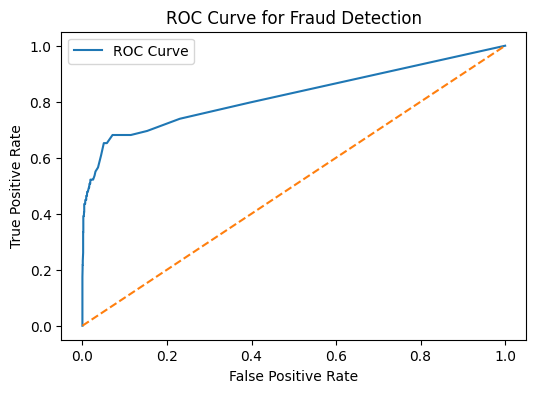

In [ ]:
#ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fraud Detection")
plt.legend()
plt.show()

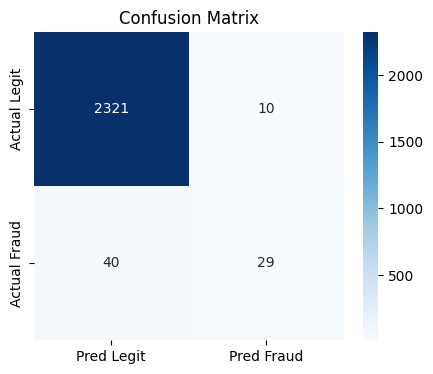

In [ ]:
#Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Legit", "Pred Fraud"],
            yticklabels=["Actual Legit", "Actual Fraud"])
plt.title("Confusion Matrix")
plt.show()